In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [125]:
df = pd.read_csv('archive/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [126]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'PMJE Energy use in MW'}, xlabel='Datetime'>

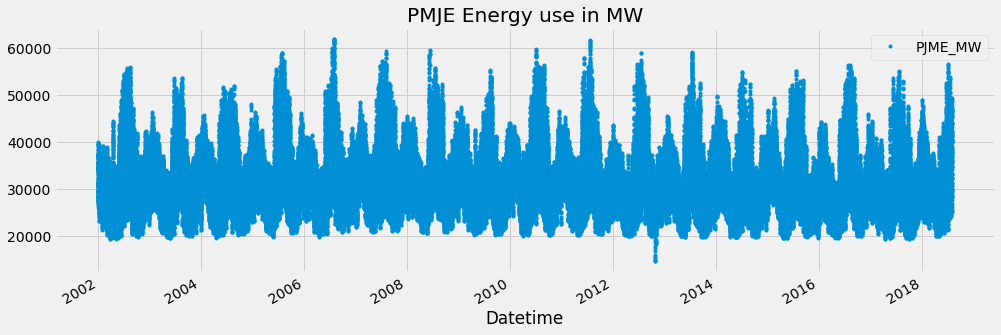

In [127]:
df.plot(style='.', figsize=(15,5), color = color_pal[0], title = 'PMJE Energy use in MW')


### Train / Test split

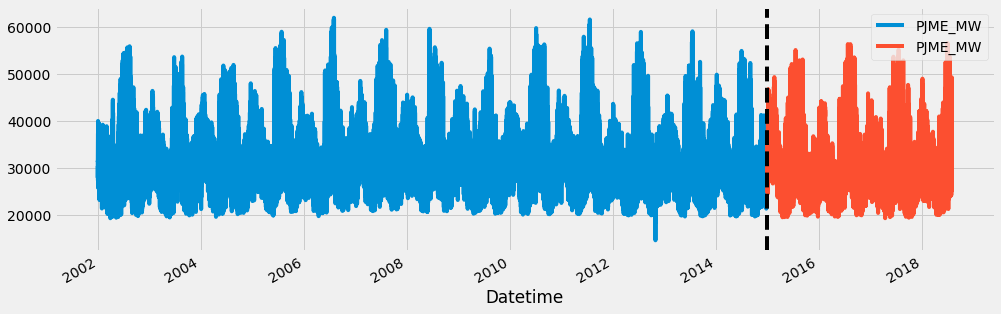

In [128]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2015', color = 'black', ls='--')
plt.show()

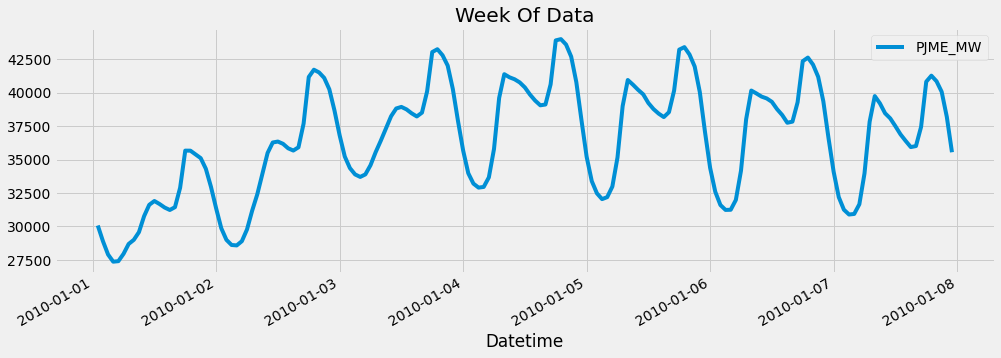

In [129]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week Of Data')
plt.show()


### Feature engineering


In [130]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [131]:
df = create_features(df)

#### Visualize our feature / target relationship

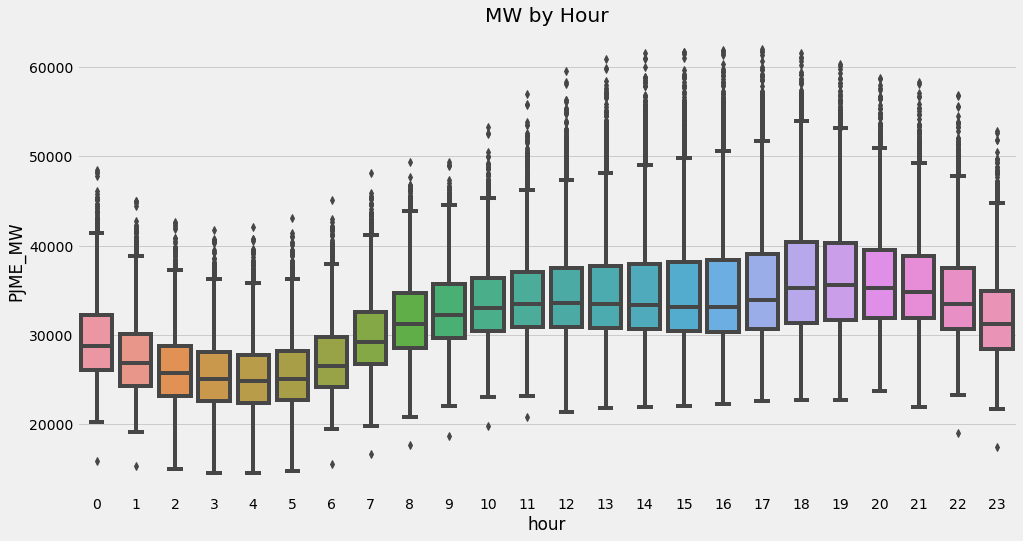

In [132]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()


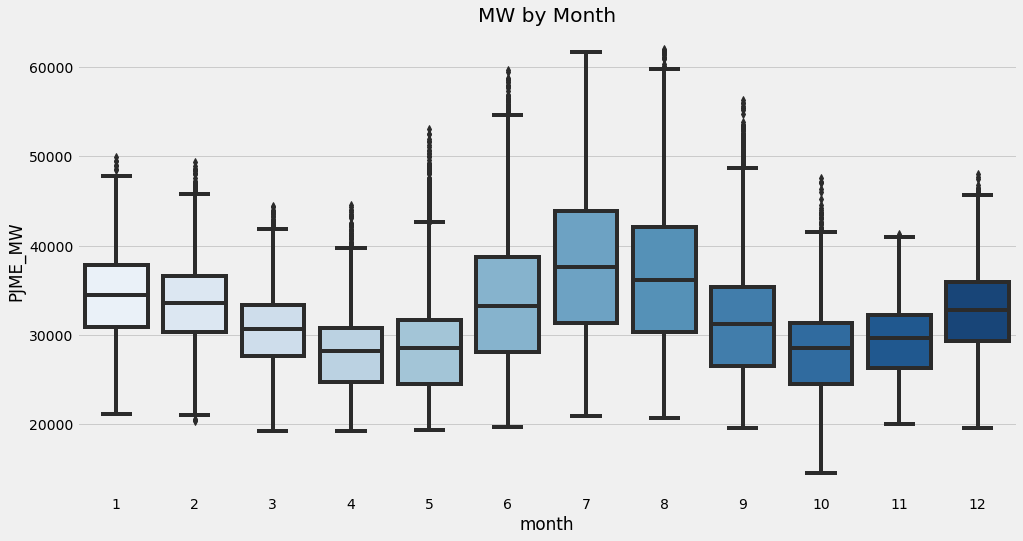

In [133]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

In [134]:
#### Create features for train set and test set

In [135]:
train_set = create_features(train)

In [136]:
test_set = create_features(test)

In [137]:
train_set.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [138]:
FEATURES = [ 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [139]:
X_train = train_set[FEATURES]
y_train = train_set[TARGET]

X_test = test_set[FEATURES]
y_test = test_set[TARGET]


### Create model


In [140]:
reg = xgb.XGBRegressor(
    n_estimators = 1000,
    early_stopping_rounds = 50,
    learning_rate = 0.01
)
reg.fit(X_train,y_train,
        eval_set = [(X_train, y_train),(X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	validation_0-rmse:28660.79477	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63482	validation_1-rmse:27422.93837
[15]	validation_0-rmse:28099.33236	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Feature Importance

In [141]:
fi = pd.DataFrame(data = reg.feature_importances_,
        index = reg.feature_names_in_,
        columns=['importance']).sort_values(['importance'])

fi

,importance
year,0.022350
quarter,0.029913
dayofyear,0.110429
dayofweek,0.159098
month,0.230090
hour,0.448121


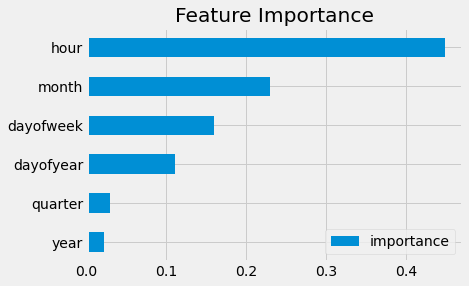

In [142]:
fi.plot(kind='barh', title='Feature Importance')
plt.show()

/Users/lorenzo/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lorenzo/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/Users/lorenzo/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the

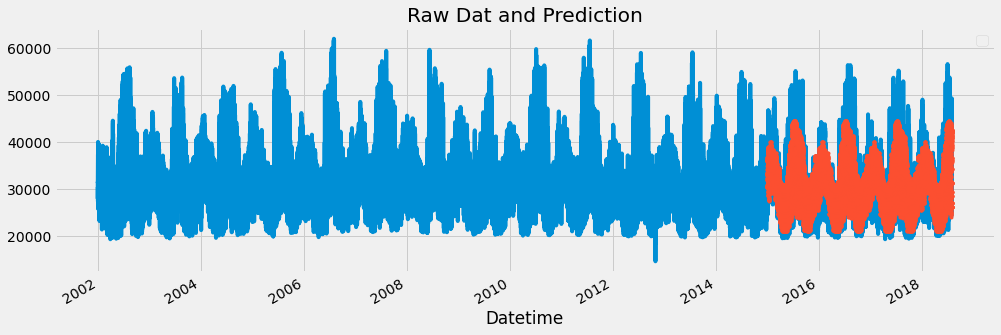

In [143]:
### Forecast on test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True,right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style = '.')
plt.legend('Truth Data', 'Predictions')
ax.set_title('Raw Dat and Prediction')
plt.show()

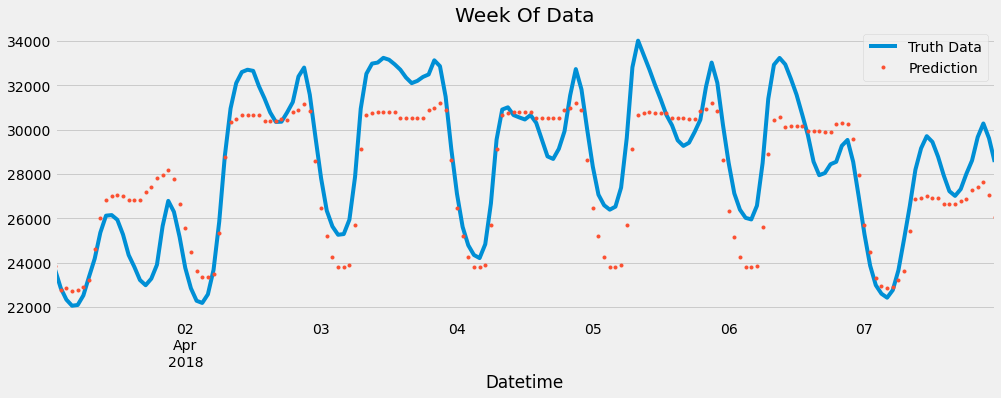

In [144]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Score (RMSE)

In [145]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3714.53


### Calculate Error

In [146]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [147]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
2018-01-06    10954.087728
2015-02-20    10897.302327
2016-08-11    10353.234131
2018-01-07    10226.969727
2017-05-19    10196.744385
Name: error, dtype: float64